# Does Enhancing Images also Enhance the Outcome of Image Recognition of Neural Networks

# General Layout for this program

1. Imports
2. Load the training set
3. Load in the test set
4. Load in the test set labels
5. Create a copy of the image set and apply CLAHE to it
6. Load in 2 pretrained resnets
7. Train resnet1 on OG images, train resnet2 on CLAHE images
8. Compare performance of both

# Imports

In [36]:
import torch
import torchvision
from torch import optim
import torch.nn as nn
from torchvision import models
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms
from PIL import Image
from timeit import default_timer as timer
import cv2

# Create the Transforms

In [37]:
from statistics import mean


input_shape = (224, 224)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

# Open the ImageNet Spotted Salamanders
Loop through the imagenet training directory pulling in all 1200 Spotted Salamader images. Then create a copy of the images and label it CLAHE

Length of set = 1300


/var/folders/yw/ckylxvy95xld6whm7608ymr80000gn/T/ipykernel_7709/1306701212.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


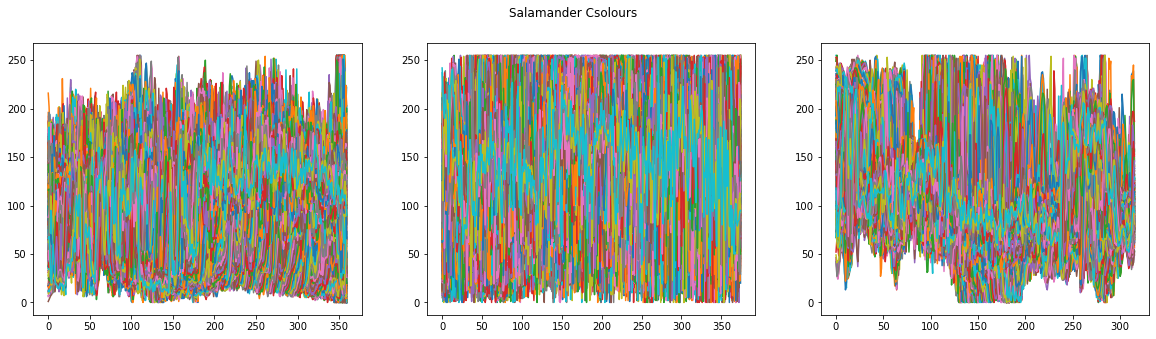

In [38]:
trainSetOG = []

directory = 'imageNet/ILSVRC/Data/CLS-LOC/train/n01632458/'

#Load in all salamader images
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        #trainSetOG.append(cv2.imread(f, 0))
        trainSetOG.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))

#copy it 
trainSetCLAHE = trainSetOG

print('Length of set = ' + str(len(trainSetCLAHE)))

cv2.imshow('image', trainSetOG[0])


fig, (ax1, ax2, ax3) = plt.subplots(1, 3,  figsize = (20, 5))

fig.suptitle('Salamander Csolours')
ax1.plot(trainSetOG[0])
ax2.plot(trainSetOG[1])    
ax3.plot(trainSetOG[2])
fig.show()

# Practice transforming

In [39]:
model = models.resnet18(pretrained=True)   #load resnet18 model
num_features = model.fc.in_features     #extract fc layers features
model.fc = nn.Linear(num_features, 2) #(num_of_class == 2)

/Users/ian/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ian/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [40]:
from torch.utils.data import Dataset, DataLoader


In [41]:
# transforms = transforms.Compose(
# [
#     transforms.ToTensor()
# ])

directory = 'imageNet/ILSVRC/Data/CLS-LOC/train/n01632458/'
train_dataset = torchvision.datasets.ImageFolder(root='imageNet/ILSVRC/Data/CLS-LOC/train/sals/', transform=transforms)

In [50]:
batch_size = 100
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [51]:
images = next(iter(train_loader)) 


TypeError: 'DataLoader' object is not subscriptable

ok test the training it on an image

In [ ]:
inputs = torch.from_numpy(trainSetOG[0])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object

print(type(device))

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())


model.train()
running_loss = 0.   #(set loss 0)
running_corrects = 0 
inputs = inputs.to(device)
labels = 1
# forward inputs and get output
optimizer.zero_grad()
outputs = model(inputs)
_, preds = torch.max(outputs, 1)
loss = criterion(outputs, labels)
# get loss value and update the network weights
loss.backward()
optimizer.step()
running_loss += loss.item() * inputs.size(0)
running_corrects += torch.sum(preds == labels.data)
epoch_loss = running_loss / len(trainSetOG)
epoch_acc = running_corrects / len(trainSetOG) * 100.
#print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() -start_time))

<class 'torch.device'>


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [375, 500]

# Load in the test images. Make a copy and name it CLAHE. 
For the test images. We are going to take 200 images out of the train set (200/1300 original images) and another 200 from a random set. Then we will have a 200 + 200 length test set with labels.  
Asumption here is that the test set doesnt have Salamander images. I cannot find list of labels for the test set so I'll have to assume for the time being.

In [ ]:
testSetOG = trainSetOG[:200]
labelSet = [True] * 200

del(trainSetOG[:200])

directory = 'imageNet/ILSVRC/Data/CLS-LOC/test/'

maxCount = 0
for filename in os.listdir(directory):
    maxCount += 1

    if (maxCount == 200):
        break

    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):
        #trainSetOG.append(cv2.imread(f, 0))
        testSetOG.append(cv2.imread(f, cv2.IMREAD_GRAYSCALE))
        labelSet.append(False)


testSetCLAHE = testSetOG


# Applying CLAHE to img set copy

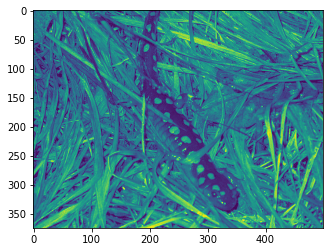

In [ ]:
clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))

#Applying clahe to all the images
for image in trainSetCLAHE:
    image = clahe.apply(image)

plt.imshow(trainSetCLAHE[0])

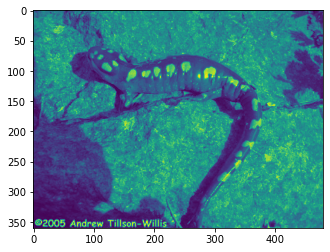

In [ ]:
clahe = cv2.createCLAHE(clipLimit=15.0, tileGridSize=(8,8))

#Applying clahe to all the images
for image in testSetCLAHE:
    image = clahe.apply(image)

plt.imshow(testSetCLAHE[0])

# Load in the 2 pretained resnets

In [ ]:
#Load in resnet 18
model = torchvision.models.resnet18(pretrained = True)  #selects a resnet model to use

#Freeze the weights of the model
for param in model.parameters():
    param.requires_grad = False

#model.eval() #Freezes the model so it stops learning so you can run tests on it?

/Users/ian/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/ian/miniforge3/envs/ml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Loss and Optimizer

In [ ]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())


# Convert images from 2d arrays into 4d tensors

In [ ]:
from turtle import shape


def imgToTensors(img):
    img = img.reshape(1, 1, img.shape[0], img.shape[1])
    img = torch.from_numpy(img)    
    model.train()
    #model.train(img2)
    
    print(img.size())
    model(img)

    

for img in trainSetCLAHE:
    imgToTensors(img)
    break
    

torch.Size([1, 1, 375, 500])


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 1, 375, 500] to have 3 channels, but got 1 channels instead

# Training the ResNets

In [ ]:
#transform = transforms.Compose([[transforms.CenterCrop((96,98))]])
print(dir(torchvision.transforms))
# trans = nn.Sequential([
#     torchvision.transforms.CenterCrop((96,98))
# ])

trans = transforms.Compose([
    transforms.CenterCrop((96,98))
])

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          answers,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        # print(type(train_loader))
        # print(train_loader[0])

        #for ii, (data, target) in enumerate(train_loader):
        for img in train_loader:

            #Turn np array into tensor
            img = torch.from_numpy(img)   

            # Clear gradients
            optimizer.zero_grad()

            print(type(img))
            
            #img = trans(img)
            #img = torch.reshape(img, (64, 3, 7, 7))

            #print(type(img))
            #print(img.shape)
            # Predicted outputs are log probabilities
            output = model(img)

            # Loss and backpropagation of gradients
            loss = criterion(output, True)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * len(trainSetCLAHE)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(True)
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * len(trainSetCLAHE)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                #for data, target in valid_loader:
                for image, value in zip(valid_loader, answers):
                    # Forward pass
                    output = model(image)

                    # Validation loss
                    loss = criterion(output, value)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * image.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(value.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * image.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

['AugMix', 'AutoAugment', 'AutoAugmentPolicy', 'CenterCrop', 'ColorJitter', 'Compose', 'ConvertImageDtype', 'ElasticTransform', 'FiveCrop', 'GaussianBlur', 'Grayscale', 'InterpolationMode', 'Lambda', 'LinearTransformation', 'Normalize', 'PILToTensor', 'Pad', 'RandAugment', 'RandomAdjustSharpness', 'RandomAffine', 'RandomApply', 'RandomAutocontrast', 'RandomChoice', 'RandomCrop', 'RandomEqualize', 'RandomErasing', 'RandomGrayscale', 'RandomHorizontalFlip', 'RandomInvert', 'RandomOrder', 'RandomPerspective', 'RandomPosterize', 'RandomResizedCrop', 'RandomRotation', 'RandomSolarize', 'RandomVerticalFlip', 'Resize', 'TenCrop', 'ToPILImage', 'ToTensor', 'TrivialAugmentWide', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '_pil_constants', '_presets', 'autoaugment', 'functional', 'functional_pil', 'functional_tensor', 'transforms']


// Need to add transforms to crop the image to 96X98

In [ ]:
model, history = train(
    model,
    criterion,
    optimizer,
    trainSetCLAHE,
    testSetCLAHE,
    labelSet,
    save_file_name="answers.txt",
    max_epochs_stop=5,
    n_epochs=30,
    print_every=2
)

Starting Training from Scratch.

<class 'torch.Tensor'>


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [375, 500]